# Otto商品分类——XGBoost训练
原始特征

我们以Kaggle 2015年举办的Otto Group Product Classification Challenge竞赛数据为例，进行XGBoost参数调优探索。
Otto数据集是著名电商Otto提供的一个多类商品分类问题，类别数=9. 每个样本有93维数值型特征（整数，表示某种事件发生的次数，已经进行过脱敏处理）。 

竞赛官网：https://www.kaggle.com/c/otto-group-product-classification-challenge/data

XGBoost的主要超参数包括：
1. 树的数目n_estimators 和 学习率 learning_rate
2. 树的最大深度max_depth
3. 叶子结点的最小样本数:min_child_weight
4. 每棵树的列采样比例：colsample_bytree
5. 每棵树的行采样比例：subsample
6. 正则化参数lambda_l1(reg_alpha), lambda_l2(reg_lambda)

对n_estimators，XGBoost学习的过程内嵌了cv，速度快。
其他参数用GridSearchCV。

## 首先 import 必要的模块

In [1]:
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.model_selection import GridSearchCV

import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## 读取数据

In [38]:
# path to where the data lies
dpath = './data/'
train = pd.read_csv(dpath +"Otto_train.csv")
#train.head()

In [39]:
# drop ids and get labels
y_train = train['target']

#XGBoost只接受数字型标签
y_train = y_train.map(lambda s: s[6:])
y_train = y_train.map(lambda s: int(s)-1)

X_train = train.drop(["id", "target"], axis=1)

#保存特征名字以备后用（可视化）
feat_names = X_train.columns 

#sklearn的学习器大多之一稀疏数据输入，模型训练会快很多
#查看一个学习器是否支持稀疏数据，可以看fit函数是否支持: X: {array-like, sparse matrix}.
#可自行用timeit比较稠密数据和稀疏数据的训练时间
from scipy.sparse import csr_matrix
X_train = csr_matrix(X_train)

### 不同参数调优用相同的交叉验证数据分折

In [4]:
# prepare cross validation
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=3)

## 第一步：学习率为0.1，粗调基学习器的数目n_estimators

In [27]:
MAX_ROUNDS = 10000

#直接调用xgboost内嵌的交叉验证（cv），可对连续的n_estimators参数进行快速交叉验证
#而GridSearchCV只能对有限个参数进行交叉验证
def get_n_estimators(params, X_train , y_train , early_stopping_rounds=10):
    xgb_params = params.copy()
    
    #准备数据
    xgb_train = xgb.DMatrix(X_train, label = y_train)
        
    #模型训练/超参数调优    
    cvresult = xgb.cv(xgb_params, xgb_train, num_boost_round=MAX_ROUNDS, nfold=3,
             metrics='mlogloss', early_stopping_rounds=early_stopping_rounds,seed=3)
  
    cvresult.to_csv('1_nestimators.csv', index_label = 'n_estimators')
    
    #最佳参数n_estimators
    n_estimators = cvresult.shape[0]
    
         
    print('best n_estimators:' , n_estimators)
    print('best cv score:' , cvresult['test-mlogloss-mean'][n_estimators-1])
     
    return n_estimators

In [ ]:
#初始参数
params = {'learning_rate': 0.1,
          #'n_estimators': 1000
          'min_child_weight': 1,
          'max_depth': 5,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          'objective': 'multi:softprob',
          'num_class':9,
          'n_jobs': 4
         }

n_estimators_1 = get_n_estimators(params , X_train , y_train)

## 第二步：调整树的参数：max_depth & min_child_weight

这两个参数尽可能一起调，因为max_depth和min_child_weight都直接影响树模型的复杂度。
如果计算资源有限，也可类似坐标轴下降，先调其中一个，然后调另一个。
如果是分类任务，且不同类的样本数目不均衡，最好先调min_child_weight，以免max_depth对少数类样本过拟合。

### 粗调，参数的步长为2

#### 设置参数搜索范围

In [7]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
max_depth = range(5,10,2)
min_child_weight = range(1,6,2)
tuned_params = dict(max_depth=max_depth, min_child_weight=min_child_weight)

#### 设置其他参数值
第一轮参数调整得到的n_estimators最优值（636），其余参数继续默认值

In [ ]:
params = {'learning_rate': 0.1,
          'n_estimators': 636,   #第一轮参数调整得到的n_estimators最优值
          #'min_child_weight': 1,
          #'max_depth': 5,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          #'tree_method':'hist',
          #'max_bin':127,
          'objective': 'multi:softprob',
          'nthread': 4
         }

xgb_g = XGBClassifier(silent=False,  **params)

#### 交叉验证 GridSearchCV
等待（XGBoost在特征数目少一倍的情况下，一次fit的时间差不多是和LightGBM的两倍）

用交叉验证评价模型性能时，用scoring参数定义评价指标。评价指标是越高越好，因此用一些损失函数当评价指标时，需要再加负号，如neg_log_loss，neg_mean_squared_error 
详见sklearn文档：http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss

In [14]:
grid_search = GridSearchCV(xgb_g, param_grid = tuned_params, scoring='neg_log_loss',n_jobs=4, cv=kfold,verbose=5, refit = False)
grid_search.fit(X_train , y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=5, min_child_weight=1 .................................
[CV] max_depth=5, min_child_weight=1 .................................
[CV] max_depth=5, min_child_weight=1 .................................
[CV] max_depth=5, min_child_weight=3 .................................
[CV]  max_depth=5, min_child_weight=1, score=-0.485512125446, total= 5.8min
[CV] max_depth=5, min_child_weight=3 .................................
[CV]  max_depth=5, min_child_weight=3, score=-0.473845466821, total= 5.8min
[CV] max_depth=5, min_child_weight=3 .................................
[CV]  max_depth=5, min_child_weight=1, score=-0.473514989822, total= 5.8min
[CV] max_depth=5, min_child_weight=5 .................................
[CV]  max_depth=5, min_child_weight=1, score=-0.482563729466, total= 5.8min
[CV] max_depth=5, min_child_weight=5 .................................
[CV]  max_depth=5, min_child_weight=5, score=-0.481682384189, total=

[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 21.4min


[CV]  max_depth=7, min_child_weight=1, score=-0.503130429303, total= 7.5min
[CV] max_depth=7, min_child_weight=3 .................................
[CV]  max_depth=7, min_child_weight=1, score=-0.507058924646, total= 7.7min
[CV] max_depth=7, min_child_weight=5 .................................
[CV]  max_depth=7, min_child_weight=3, score=-0.48391583136, total= 8.0min
[CV] max_depth=7, min_child_weight=5 .................................
[CV]  max_depth=7, min_child_weight=3, score=-0.497244434862, total= 7.8min
[CV] max_depth=7, min_child_weight=5 .................................
[CV]  max_depth=7, min_child_weight=5, score=-0.479057997648, total= 7.8min
[CV] max_depth=9, min_child_weight=1 .................................
[CV]  max_depth=7, min_child_weight=3, score=-0.487922322336, total= 8.1min
[CV] max_depth=9, min_child_weight=1 .................................
[CV]  max_depth=7, min_child_weight=5, score=-0.48444741855, total= 7.8min
[CV] max_depth=9, min_child_weight=1 .......

[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed: 57.8min finished


({'max_depth': 5, 'min_child_weight': 3}, -0.48002748345913354)

#### 交叉验证结果可视化

Best: -0.480027 using {'max_depth': 5, 'min_child_weight': 3}


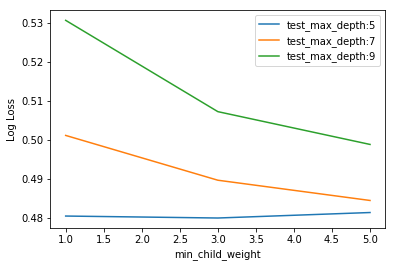

In [20]:
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
test_means = grid_search.cv_results_[ 'mean_test_score' ]
#test_stds = grid_search.cv_results_[ 'std_test_score' ]
#train_means = grid_search.cv_results_[ 'mean_train_score' ]
#train_stds = grid_search.cv_results_[ 'std_train_score' ]

pd.DataFrame(grid_search.cv_results_).to_csv('maxdepth_min_child_weights_1.csv')

# plot results
test_scores = np.array(test_means).reshape(len(max_depth), len(min_child_weight))
#train_scores = np.array(train_means).reshape(len(max_depth), len(min_child_weight))

for i, value in enumerate(max_depth):
    plt.plot(min_child_weight, -test_scores[i], label= 'test_max_depth:'   + str(value))

plt.legend()
plt.xlabel( 'min_child_weight' )                                                                                                      
plt.ylabel( 'Log Loss' )
plt.savefig('max_depth_and_min_child_weght_1.png' )

### 微调，参数的步长为1

In [21]:
#step=1，继续微调
max_depth = range(4,7,1) #4，5，6
min_child_weight = range(2,5,1)  #2，3，4
tuned_params = dict(max_depth=max_depth, min_child_weight=min_child_weight)

In [22]:
params = {'learning_rate': 0.1,
          'n_estimators': 636,   #第一轮参数调整得到的n_estimators最优值
          #'min_child_weight': 1,
          #'max_depth': 5,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          #'tree_method':'hist',
          #'max_bin':127,
          'objective': 'multi:softprob',
          'nthread': 4
         }

xgb_g = XGBClassifier(silent=False,  **params)

grid_search = GridSearchCV(xgb_g, param_grid = tuned_params, scoring='neg_log_loss',n_jobs=4, cv=kfold,verbose=5, refit = False)
grid_search.fit(X_train , y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=4, min_child_weight=2 .................................
[CV] max_depth=4, min_child_weight=2 .................................
[CV] max_depth=4, min_child_weight=2 .................................
[CV] max_depth=4, min_child_weight=3 .................................
[CV]  max_depth=4, min_child_weight=2, score=-0.489539473449, total= 4.6min
[CV] max_depth=4, min_child_weight=3 .................................
[CV]  max_depth=4, min_child_weight=3, score=-0.484778810571, total= 4.6min
[CV] max_depth=4, min_child_weight=3 .................................
[CV]  max_depth=4, min_child_weight=2, score=-0.485230050286, total= 4.8min
[CV]  max_depth=4, min_child_weight=2, score=-0.493611367402, total= 4.8min
[CV] max_depth=4, min_child_weight=4 .................................
[CV] max_depth=4, min_child_weight=4 .................................
[CV]  max_depth=4, min_child_weight=3, score=-0.495543069456, total=

[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 16.7min


[CV]  max_depth=5, min_child_weight=2, score=-0.485505132629, total= 5.8min
[CV] max_depth=5, min_child_weight=3 .................................
[CV]  max_depth=5, min_child_weight=2, score=-0.482410761547, total= 6.0min
[CV] max_depth=5, min_child_weight=4 .................................
[CV]  max_depth=5, min_child_weight=3, score=-0.473845466821, total= 5.9min
[CV] max_depth=5, min_child_weight=4 .................................
[CV]  max_depth=5, min_child_weight=3, score=-0.481352269877, total= 5.7min
[CV] max_depth=5, min_child_weight=4 .................................
[CV]  max_depth=5, min_child_weight=4, score=-0.475487674611, total= 5.8min
[CV]  max_depth=5, min_child_weight=3, score=-0.484885784203, total= 5.8min
[CV] max_depth=6, min_child_weight=2 .................................
[CV] max_depth=6, min_child_weight=2 .................................
[CV]  max_depth=5, min_child_weight=4, score=-0.480553142104, total= 5.7min
[CV] max_depth=6, min_child_weight=2 .....

[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed: 42.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=636, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=0.7),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'max_depth': [4, 5, 6], 'min_child_weight': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_log_loss', verbose=5)

Best: -0.480027 using {'max_depth': 5, 'min_child_weight': 3}


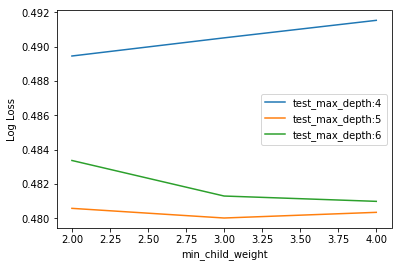

In [23]:
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
test_means = grid_search.cv_results_[ 'mean_test_score' ]

pd.DataFrame(grid_search.cv_results_).to_csv('maxdepth_min_child_weights_2.csv')

# plot results
test_scores = np.array(test_means).reshape(len(max_depth), len(min_child_weight))

for i, value in enumerate(max_depth):
    plt.plot(min_child_weight, -test_scores[i], label= 'test_max_depth:'   + str(value))

plt.legend()
plt.xlabel( 'min_child_weight' )                                                                                                      
plt.ylabel( 'Log Loss' )
plt.savefig('max_depth_and_min_child_weght_2.png' )

## 第三步 行采样比例

In [5]:
subsample_s = [i/10.0 for i in range(5,10)]
tuned_params = dict(subsample=subsample_s)

In [6]:
params = {'learning_rate': 0.1,
          'n_estimators': 636,   #第一轮参数调整得到的n_estimators最优值
          'min_child_weight': 3,
          'max_depth': 5,
          #'subsample': 0.7,
          'colsample_bytree': 0.7,
          #'tree_method':'hist',
          #'max_bin':127,
          'objective': 'multi:softprob',
          'nthread': 4
         }

xgb_g = XGBClassifier(silent=False,  **params)

grid_search = GridSearchCV(xgb_g, param_grid = tuned_params, scoring='neg_log_loss',n_jobs=4, cv=kfold,verbose=5, refit = False)
grid_search.fit(X_train , y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] subsample=0.5 ...................................................
[CV] subsample=0.5 ...................................................
[CV] subsample=0.5 ...................................................
[CV] subsample=0.6 ...................................................
[CV] .............. subsample=0.5, score=-0.47752024231, total= 5.2min
[CV] subsample=0.6 ...................................................
[CV] ............. subsample=0.5, score=-0.489447544338, total= 5.2min
[CV] subsample=0.6 ...................................................
[CV] ............. subsample=0.5, score=-0.484413982984, total= 5.8min
[CV] subsample=0.7 ...................................................
[CV] ............. subsample=0.6, score=-0.476766441127, total= 5.8min
[CV] subsample=0.7 ...................................................
[CV] ............. subsample=0.6, score=-0.487572875712, total= 6.0min
[CV] subsample=0.

[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed: 18.7min remaining:  4.7min


[CV] ............. subsample=0.9, score=-0.475223752905, total= 4.4min
[CV] ............. subsample=0.9, score=-0.481473296606, total= 4.4min
[CV] ............. subsample=0.9, score=-0.485303165025, total= 4.1min


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 23.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=3, missing=None, n_estimators=636, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=False, subsample=1),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_log_loss', verbose=5)

Best: -0.480027 using {'subsample': 0.7}


/Users/qing/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/qing/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/qing/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/qing/anaconda2/lib/python2.7/

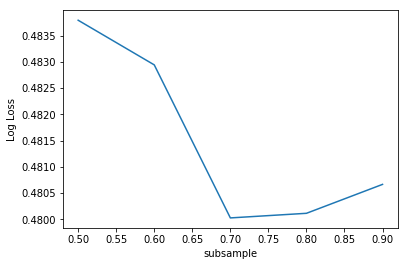

In [7]:
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
test_means = grid_search.cv_results_[ 'mean_test_score' ]

pd.DataFrame(grid_search.cv_results_).to_csv('subsample.csv')

plt.plot(subsample_s, -test_means)

plt.legend()
plt.xlabel( 'subsample' )                                                                                                      
plt.ylabel( 'Log Loss' )
plt.savefig('subsample.png' )

## 第四步 列采样比例

In [8]:
colsample_bytree_s = [i/10.0 for i in range(5,10)]
tuned_params = dict(colsample_bytree=colsample_bytree_s)

In [9]:
params = {'learning_rate': 0.1,
          'n_estimators': 636,   #第一轮参数调整得到的n_estimators最优值
          'min_child_weight': 3,
          'max_depth': 5,
          'subsample': 0.7,
          #'colsample_bytree': 0.7,
          #'tree_method':'hist',
          #'max_bin':127,
          'objective': 'multi:softprob',
          'nthread': 4
         }

xgb_g = XGBClassifier(**params)

grid_search = GridSearchCV(xgb_g, param_grid = tuned_params, scoring='neg_log_loss',n_jobs=4, cv=kfold,verbose=5, refit = False)
grid_search.fit(X_train , y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] colsample_bytree=0.5 ............................................
[CV] colsample_bytree=0.5 ............................................
[CV] colsample_bytree=0.5 ............................................
[CV] colsample_bytree=0.6 ............................................
[CV] ...... colsample_bytree=0.5, score=-0.486013164118, total= 4.2min
[CV] colsample_bytree=0.6 ............................................
[CV] ...... colsample_bytree=0.5, score=-0.481436542177, total= 4.4min
[CV] colsample_bytree=0.6 ............................................
[CV] ...... colsample_bytree=0.5, score=-0.475645835683, total= 4.4min
[CV] colsample_bytree=0.7 ............................................
[CV] ...... colsample_bytree=0.6, score=-0.474697201327, total= 4.9min
[CV] colsample_bytree=0.7 ............................................
[CV] ...... colsample_bytree=0.6, score=-0.480589755645, total= 4.8min
[CV] colsample_by

[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed: 18.4min remaining:  4.6min


[CV] ...... colsample_bytree=0.9, score=-0.475230991002, total= 5.2min
[CV] ...... colsample_bytree=0.9, score=-0.482775285185, total= 4.9min
[CV] ...... colsample_bytree=0.9, score=-0.488149128472, total= 4.6min


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 22.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=3, missing=None, n_estimators=636, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.7),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='neg_log_loss', verbose=5)

Best: -0.480027 using {'colsample_bytree': 0.7}


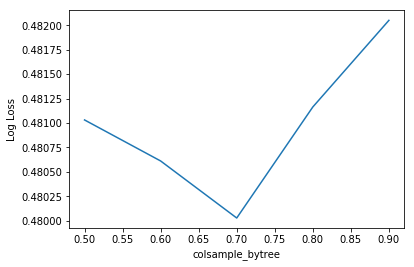

In [10]:
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
test_means = grid_search.cv_results_[ 'mean_test_score' ]

pd.DataFrame(grid_search.cv_results_).to_csv('colsample_bytree.csv')

plt.plot(colsample_bytree_s, -test_means)

plt.legend()
plt.xlabel( 'colsample_bytree' )                                                                                                      
plt.ylabel( 'Log Loss' )
plt.savefig('colsample_bytree.png' )

In [11]:
test_means

array([-0.48103151, -0.48061147, -0.48002748, -0.48116435, -0.48205138])

## 第五步 正则系数reg_lambda
reg_lambda:L2正则
默认为1

In [13]:
reg_lambda_s = range(0,4,2)
tuned_params = dict(reg_lambda =reg_lambda_s)

In [14]:
params = {'learning_rate': 0.1,
          'n_estimators': 636,   #第一轮参数调整得到的n_estimators最优值
          'min_child_weight': 3,
          'max_depth': 5,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          #'tree_method':'hist',
          #'max_bin':127,
          'objective': 'multi:softprob',
          'nthread': 4
         }

xgb_g = XGBClassifier(**params)

grid_search = GridSearchCV(xgb_g, param_grid = tuned_params, scoring='neg_log_loss',n_jobs=4, cv=kfold,verbose=5, refit = False)
grid_search.fit(X_train , y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] reg_lambda=0 ....................................................
[CV] reg_lambda=0 ....................................................
[CV] reg_lambda=0 ....................................................
[CV] reg_lambda=2 ....................................................
[CV] .............. reg_lambda=0, score=-0.486662387901, total= 5.1min
[CV] reg_lambda=2 ....................................................
[CV] .............. reg_lambda=0, score=-0.475698975088, total= 5.1min
[CV] reg_lambda=2 ....................................................
[CV] .............. reg_lambda=2, score=-0.475021685319, total= 5.3min


[Parallel(n_jobs=4)]: Done   3 out of   6 | elapsed:  6.0min remaining:  6.0min


[CV] .............. reg_lambda=0, score=-0.484914845906, total= 5.4min
[CV] .............. reg_lambda=2, score=-0.483000982249, total= 2.8min
[CV] .............. reg_lambda=2, score=-0.481599221878, total= 3.1min


[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:  9.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=3, missing=None, n_estimators=636, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.7),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'reg_lambda': [0, 2]}, pre_dispatch='2*n_jobs',
       refit=False, return_train_score='warn', scoring='neg_log_loss',
       verbose=5)

Best: -0.479874 using {'reg_lambda': 2}


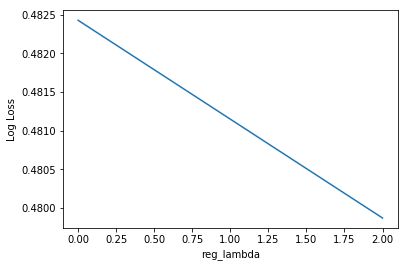

In [16]:
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
test_means = grid_search.cv_results_[ 'mean_test_score' ]

pd.DataFrame(grid_search.cv_results_).to_csv('reg_lambda.csv')

plt.plot(reg_lambda_s, -test_means)

plt.legend()
plt.xlabel( 'reg_lambda' )                                                                                                      
plt.ylabel( 'Log Loss' )
plt.savefig('reg_lambda.png' )

In [20]:
-test_means

array([ 0.48242505,  0.47987371])

默认参数值1对应的模型性能为0.480027，比最佳参数值2的性能（0.47987371）差，参数值取2。
2为搜索范围最大值，继续扩大搜索范围。

In [18]:
reg_lambda_s = range(3,6,1)
tuned_params = dict(reg_lambda =reg_lambda_s)

In [19]:
params = {'learning_rate': 0.1,
          'n_estimators': 636,   #第一轮参数调整得到的n_estimators最优值
          'min_child_weight': 3,
          'max_depth': 5,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          #'tree_method':'hist',
          #'max_bin':127,
          'objective': 'multi:softprob',
          'nthread': 4
         }

xgb_g = XGBClassifier(**params)

grid_search = GridSearchCV(xgb_g, param_grid = tuned_params, scoring='neg_log_loss',n_jobs=4, cv=kfold,verbose=5, refit = False)
grid_search.fit(X_train , y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] reg_lambda=3 ....................................................
[CV] reg_lambda=3 ....................................................
[CV] reg_lambda=3 ....................................................
[CV] reg_lambda=4 ....................................................
[CV] .............. reg_lambda=3, score=-0.483578849129, total= 5.1min
[CV] reg_lambda=4 ....................................................
[CV] .............. reg_lambda=3, score=-0.475353340547, total= 5.1min
[CV] reg_lambda=4 ....................................................
[CV] .............. reg_lambda=3, score=-0.481491813131, total= 5.2min
[CV] reg_lambda=5 ....................................................
[CV] .............. reg_lambda=4, score=-0.473988623793, total= 5.6min
[CV] reg_lambda=5 ....................................................


[Parallel(n_jobs=4)]: Done   4 out of   9 | elapsed:  6.0min remaining:  7.6min


[CV] .............. reg_lambda=4, score=-0.480934504323, total= 5.3min
[CV] reg_lambda=5 ....................................................
[CV] .............. reg_lambda=4, score=-0.484475485325, total= 5.3min


[Parallel(n_jobs=4)]: Done   6 out of   9 | elapsed: 11.8min remaining:  5.9min


[CV] .............. reg_lambda=5, score=-0.475187762576, total= 5.3min
[CV] .............. reg_lambda=5, score=-0.480811277388, total= 5.5min
[CV] .............. reg_lambda=5, score=-0.485396040346, total= 2.2min


[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed: 14.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=3, missing=None, n_estimators=636, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.7),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'reg_lambda': [3, 4, 5]}, pre_dispatch='2*n_jobs',
       refit=False, return_train_score='warn', scoring='neg_log_loss',
       verbose=5)

Best: -0.479799 using {'reg_lambda': 4}


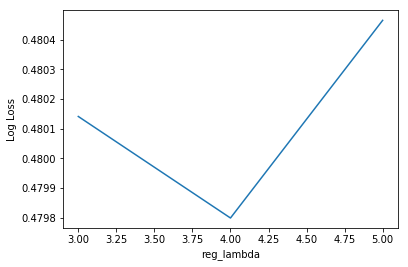

In [21]:
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
test_means = grid_search.cv_results_[ 'mean_test_score' ]

pd.DataFrame(grid_search.cv_results_).to_csv('reg_lambda2.csv')

plt.plot(reg_lambda_s, -test_means)

plt.legend()
plt.xlabel( 'reg_lambda' )                                                                                                      
plt.ylabel( 'Log Loss' )
plt.savefig('reg_lambda.png' )

In [22]:
-test_means

array([ 0.48014107,  0.4797992 ,  0.4804647 ])

reg_lambda在2（0.47987371）-5（0.4804647）之间，模型性能差异不大。考虑到另一个正则系数reg_alpha还没调，选择较小的数值2。

## 第六步 正则系数reg_alpha
reg_alpha:L1正则
默认为0

In [23]:
reg_alpha_s = range(1,5,1)
tuned_params = dict(reg_alpha =reg_alpha_s)

In [24]:
params = {'learning_rate': 0.1,
          'n_estimators': 636,   #第一轮参数调整得到的n_estimators最优值
          'min_child_weight': 3,
          'max_depth': 5,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          'reg_lambda':2,
          #'tree_method':'hist',
          #'max_bin':127,
          'objective': 'multi:softprob',
          'nthread': 4
         }

xgb_g = XGBClassifier(**params)

grid_search = GridSearchCV(xgb_g, param_grid = tuned_params, scoring='neg_log_loss',n_jobs=4, cv=kfold,verbose=5, refit = False)
grid_search.fit(X_train , y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] reg_alpha=1 .....................................................
[CV] reg_alpha=1 .....................................................
[CV] reg_alpha=1 .....................................................
[CV] reg_alpha=2 .....................................................
[CV] ............... reg_alpha=1, score=-0.484617388024, total= 5.2min
[CV] reg_alpha=2 .....................................................
[CV] ............... reg_alpha=2, score=-0.475584230917, total= 5.3min
[CV] reg_alpha=2 .....................................................
[CV] ............... reg_alpha=1, score=-0.473940302809, total= 5.4min
[CV] reg_alpha=3 .....................................................
[CV] ............... reg_alpha=1, score=-0.480972249379, total= 5.4min
[CV] reg_alpha=3 .....................................................
[CV] ............... reg_alpha=2, score=-0.483329292331, total= 5.3min
[CV] reg_alpha=3 

[Parallel(n_jobs=4)]: Done   8 out of  12 | elapsed: 12.2min remaining:  6.1min


[CV] ............... reg_alpha=4, score=-0.480538567507, total= 5.2min
[CV] ............... reg_alpha=4, score=-0.492828313253, total= 5.2min
[CV] ............... reg_alpha=3, score=-0.490455500464, total= 5.4min
[CV] ............... reg_alpha=4, score=-0.487263497519, total= 5.5min


[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 26.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=3, missing=None, n_estimators=636, nthread=4,
       objective='multi:softprob', reg_alpha=0, reg_lambda=2,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.7),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'reg_alpha': [1, 2, 3, 4]}, pre_dispatch='2*n_jobs',
       refit=False, return_train_score='warn', scoring='neg_log_loss',
       verbose=5)

Best: -0.479843 using {'reg_alpha': 1}


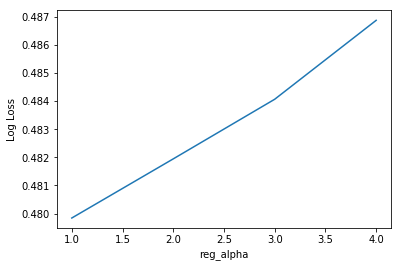

In [25]:
# summarize results
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
test_means = grid_search.cv_results_[ 'mean_test_score' ]

pd.DataFrame(grid_search.cv_results_).to_csv('reg_alpha.csv')

plt.plot(reg_alpha_s, -test_means)

plt.legend()
plt.xlabel( 'reg_alpha' )                                                                                                      
plt.ylabel( 'Log Loss' )
plt.savefig('reg_alpha.png' )

默认值0对应的模型性能为0.47987371，比参数值为1对应的性能（-0.479843）稍差。
最佳参数值取1.

## 最后，用树的最佳参数，再次调整学习率和基学习器的数目

In [30]:
params = {'num_class':9,
          'learning_rate': 0.05,
          #'n_estimators': 636,   #第一轮参数调整得到的n_estimators最优值
          'min_child_weight': 3,
          'max_depth': 5,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          'reg_lambda':2,
          'reg_alpha':1,
          #'tree_method':'hist',
          #'max_bin':127,
          'objective': 'multi:softprob',
          'nthread': 4
         }

n_estimators_2 = get_n_estimators(params , X_train , y_train)

('best n_estimators:', 1378)


KeyError: -1

学习率为0.01时学习时间太长，中止
改成0.05，得到树的数目为1000+（LightGBM中学习率为0.01时，树的数目为1000+？）

### 用所有训练数据，采用最佳参数重新训练模型
由于样本数目增多，模型复杂度稍微扩大一点？
max_depth增多1
min_child_weight按样本比例,从3增加到4

In [32]:
params = {'learning_rate': 0.05,
          'n_estimators': 1378, 
          'min_child_weight': 4,
          'max_depth': 6,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          'reg_lambda':2,
          'reg_alpha':1,
          #'tree_method':'hist',
          #'max_bin':127,
          'objective': 'multi:softprob',
          'nthread': 4
         }

xgb_g = XGBClassifier(**params)
xgb_g.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=6,
       min_child_weight=4, missing=None, n_estimators=1378, nthread=4,
       objective='multi:softprob', reg_alpha=1, reg_lambda=2,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.7)

## 保存模型，用于后续测试

In [34]:
import cPickle

cPickle.dump(xgb_g, open("Otto_XGBoost_org.pkl", 'wb'))

### 特征重要性

In [40]:
df = pd.DataFrame({"columns":list(feat_names), "importance":list(xgb_g.feature_importances_.T)})
df = df.sort_values(by=['importance'],ascending=False)

In [41]:
df

,columns,importance
66,feat_67,0.039975
23,feat_24,0.037326
47,feat_48,0.032613
85,feat_86,0.031725
24,feat_25,0.031474
39,feat_40,0.028941
13,feat_14,0.027623
63,feat_64,0.026137
15,feat_16,0.025728
61,feat_62,0.023995


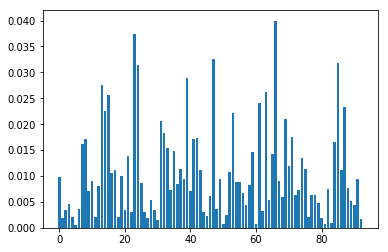

In [37]:
plt.bar(range(len(xgb_g.feature_importances_)), xgb_g.feature_importances_)
plt.show()